# TM10007 Assignment template

In [19]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [20]:
##Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
# from worcliver.load_data import load_data
import pandas as pd
#from ecg.load_data import load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import decomposition

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# feature space splitsen in labels en features
features = pd.DataFrame(data)
ground_truth = data['label']
features.pop('label')
ground_truth = ground_truth.map(lambda x: 1 if x == 'liposarcoma' else 0)

#features met alleen maar missing data verwijderen
zero_columns = [column for column in features.columns if (features[column] == 0).all()]
features = features.drop(columns=zero_columns)
print(f'The number of features (without missing data features): {len(features.columns)}')

#split data
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=42)
print(f"Aantal samples in training set: {len(X_train)}")
print(f"Aantal samples in test set: {len(X_test)}")

The number of samples: 115
The number of columns: 494
The number of features (without missing data features): 480
Aantal samples in training set: 92
Aantal samples in test set: 23


480


<ipython-input-24-cbeb40b10a45>:47: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


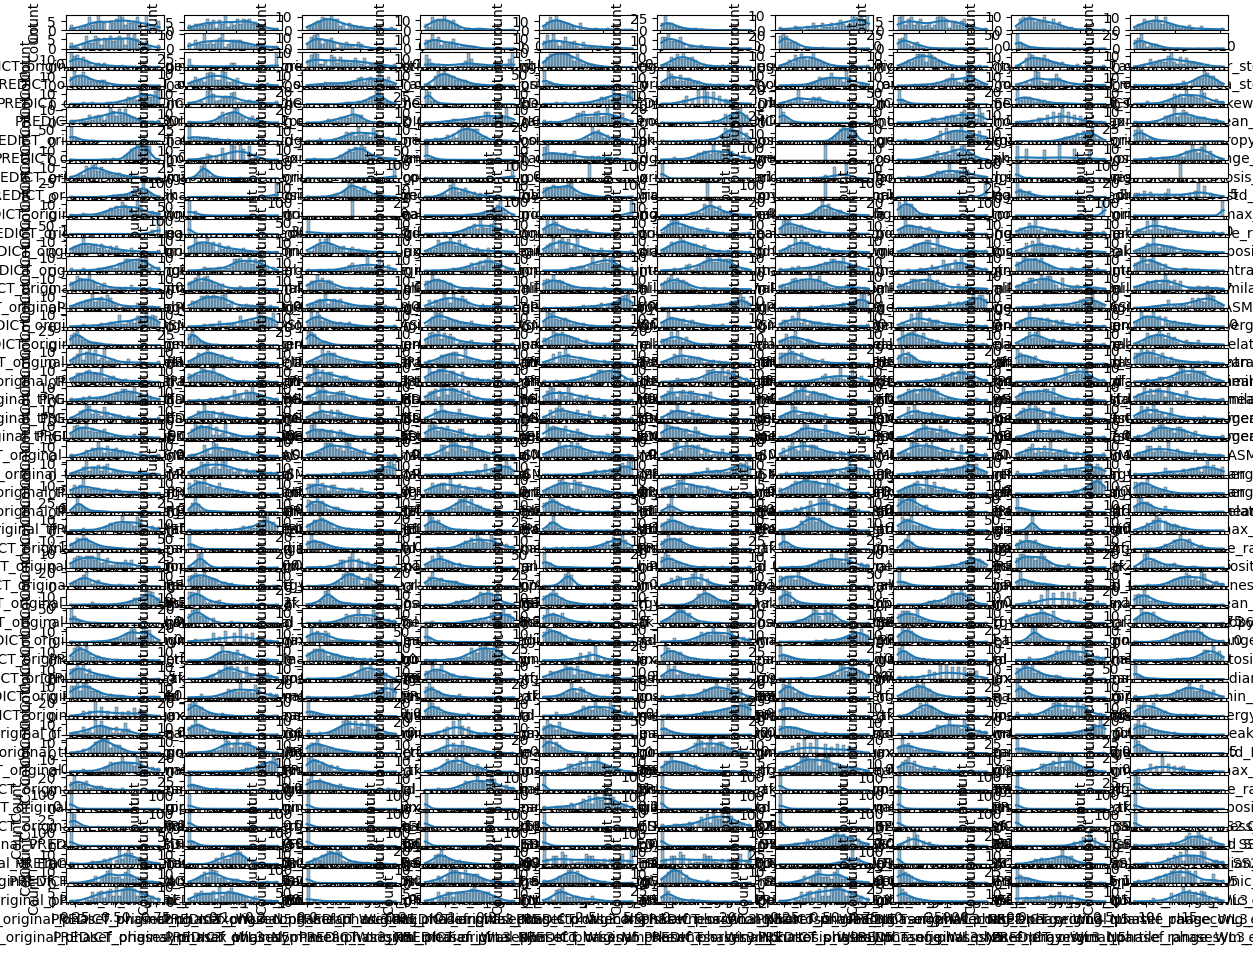

In [24]:
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm
num_cols = X_train.select_dtypes(include=['number']).columns  # Alleen numerieke kolommen
num_features = len(num_cols)  # Aantal numerieke features
print(num_features)
# Instellingen voor het plotten van meerdere histogrammen
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols[:494]):  # Eerst 20 kolommen om het overzichtelijk te houden
    plt.subplot(50, 10, i + 1)  # 4 rijen, 5 kolommen per plotpagina
    sns.histplot(data[col], bins=30, kde=True)
    # plt.title(col)
    # plt.xlabel("")
    # plt.ylabel("Frequentie")

plt.tight_layout()
plt.show()

# Controleren voor elke feature of data normaal verdeeld is

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


72
408
Aantal features normaal verdeeld in beide klassen: 69
Features die voor beide klassen normaal verdeeld zijn: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_hf_min', 'PREDICT_original_hf_entropy', 'PREDICT_original_logf_peak_position_sigma1', 'PREDICT_original_logf_entropy_sigma1', 'PREDICT_original_logf_min_sigma5', 'PREDICT_original_logf_max_sigma5', 'PREDICT_original_logf_std_sigma5', 'PREDICT_original_logf_peak_position_sigma5', 'PREDICT_original_logf_range_sigma5', 'PREDICT_original_logf_entropy_sigma5', 'PREDICT_original_logf_peak_position_sigma10', 'PREDICT_original_logf_entropy_sigma10', 'PREDICT_original_tf_LBP_max_R3_P12', 'PREDICT_original_tf_LBP_range_R3_P12', 'PREDICT_original_tf_LBP_entropy_R3_P12', 'PREDICT_original_tf_LBP_max_R8_P24', 'PREDICT_original_tf_LBP_peak_R8_P24', 'PREDICT_original_tf_LBP_peak_position_R8_P24', 'PREDICT_original_tf_LBP_entropy_R8_P24', 'PREDICT_origi

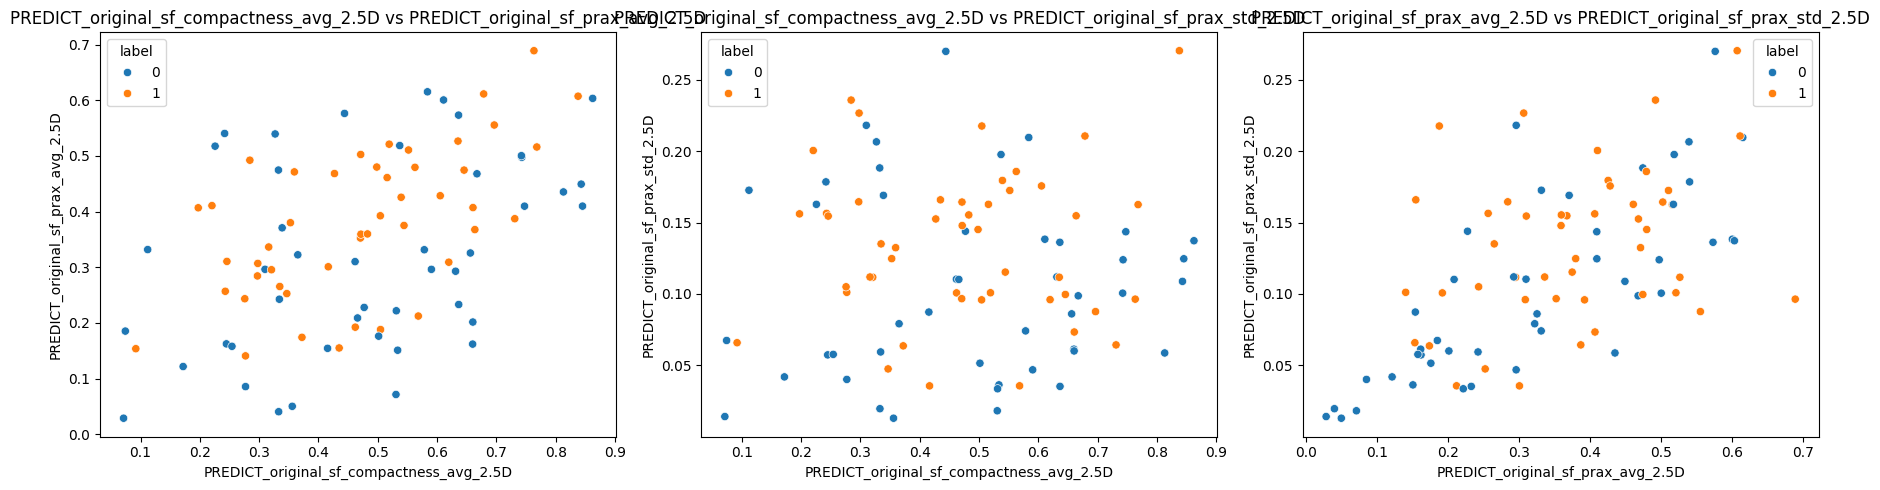

In [25]:
from scipy.stats import shapiro
normal_count = 0
not_normal_count = 0
for col in X_train:
  stat, p = shapiro(X_train[col])
  if p > 0.05:
      normal_count += 1
  else:
      not_normal_count += 1
print(normal_count)
print(not_normal_count)
# dus we kiezen voor normalization want data is voor veel features niet normaal verdeeld

normal_features = []  # Lijst om features op te slaan die voor beide klassen normaal verdeeld zijn

for col in X_train.columns:
    # Splits de feature op basis van de klassen in y_train
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    # Shapiro-Wilk test per klasse
    stat_0, p_0 = shapiro(class_0)
    stat_1, p_1 = shapiro(class_1)

    # Check of beide klassen normaal verdeeld zijn (p > 0.05)
    if p_0 > 0.05 and p_1 > 0.05:
        normal_features.append(col)

print(f"Aantal features normaal verdeeld in beide klassen: {len(normal_features)}")
print("Features die voor beide klassen normaal verdeeld zijn:", normal_features)

feature_1, feature_2, feature_3 = normal_features[:3]  # Pak de eerste drie

# Maak subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=X_train[feature_1], y=X_train[feature_2], hue=y_train, ax=axes[0])
axes[0].set_title(f'{feature_1} vs {feature_2}')
axes[0].set_xlabel(feature_1)
axes[0].set_ylabel(feature_2)

sns.scatterplot(x=X_train[feature_1], y=X_train[feature_3], hue=y_train, ax=axes[1])
axes[1].set_title(f'{feature_1} vs {feature_3}')
axes[1].set_xlabel(feature_1)
axes[1].set_ylabel(feature_3)

sns.scatterplot(x=X_train[feature_2], y=X_train[feature_3], hue=y_train, ax=axes[2])
axes[2].set_title(f'{feature_2} vs {feature_3}')
axes[2].set_xlabel(feature_2)
axes[2].set_ylabel(feature_3)

plt.tight_layout()
plt.show()

# Scalen van feature data

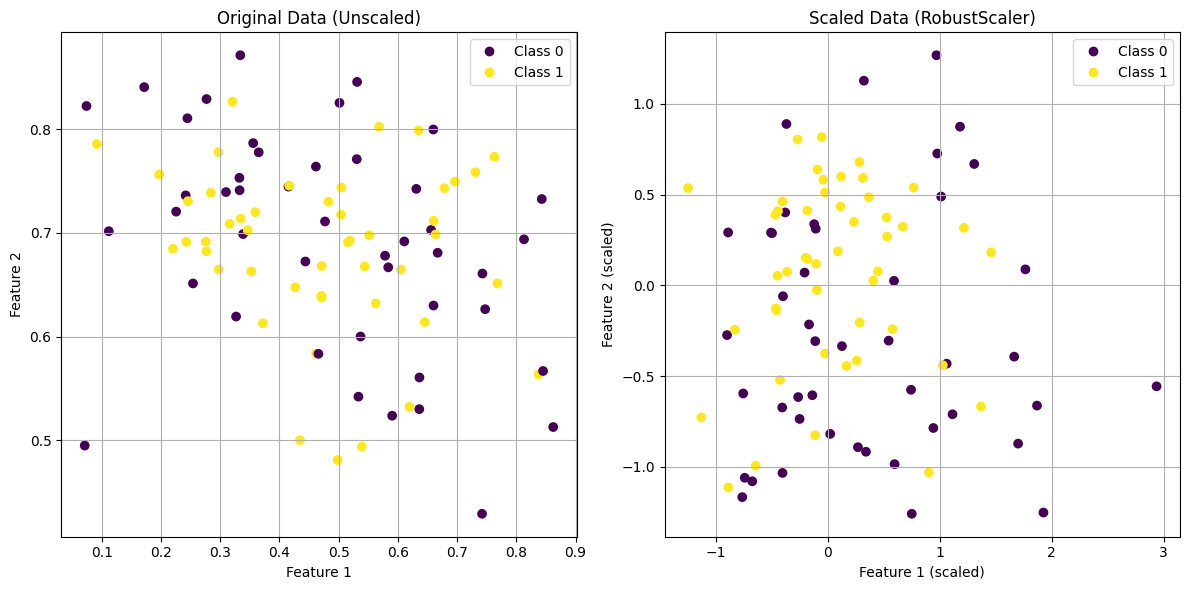

In [27]:
# scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# #scaling plotten op de eerste twee features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Eerste subplot
scatter = plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 200], c=y_train, label='Original data') #let op, deze plot is anders doordat je een dataframe hebt
plt.title('Original Data (Unscaled)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)

plt.subplot(1, 2, 2)  # Tweede subplot
scatter = plt.scatter(X_train_scaled[:, 80], X_train_scaled[:, 1], c=y_train, label='Scaled data') #hier heb je te maken met numpy arrays
plt.title('Scaled Data (RobustScaler)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature selectie

## Backwards

In [ ]:
# feature selectie
svc = svm.SVC(kernel = 'linear')
rfecv = feature_selection.RFECV(
    estimator=svc, step=1,
    cv=model_selection.StratifiedKFold(8),
    scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()
selected_features = np.where(rfecv.support_)[0]
print("Geselecteerde features:", selected_features)


## Principal component analysis

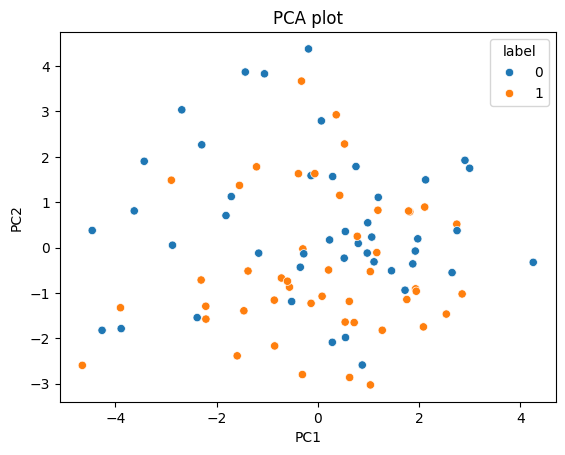

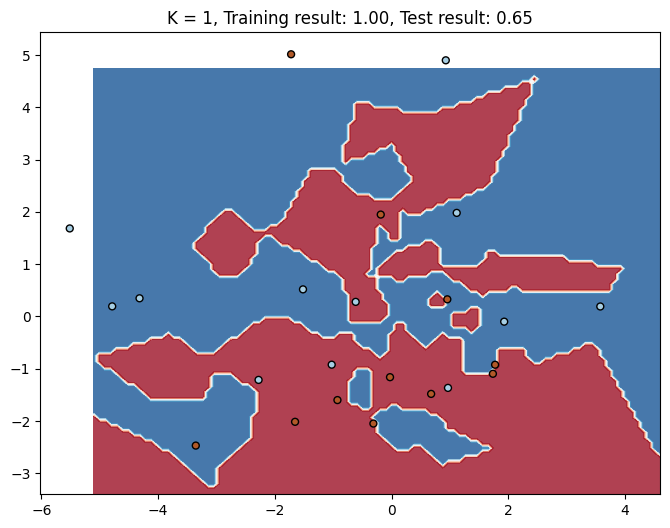

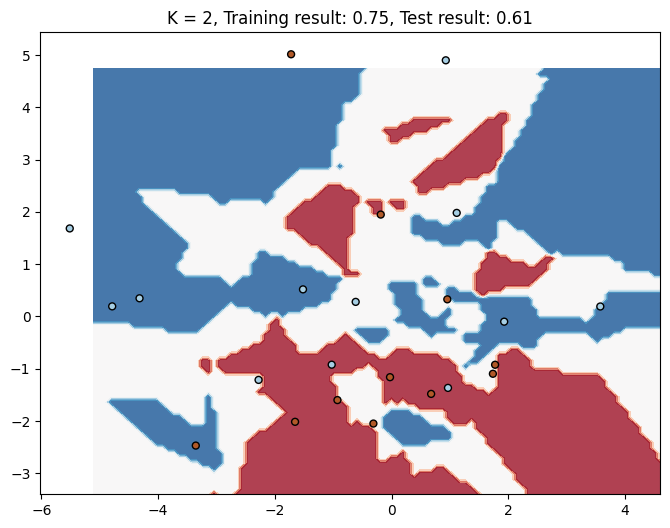

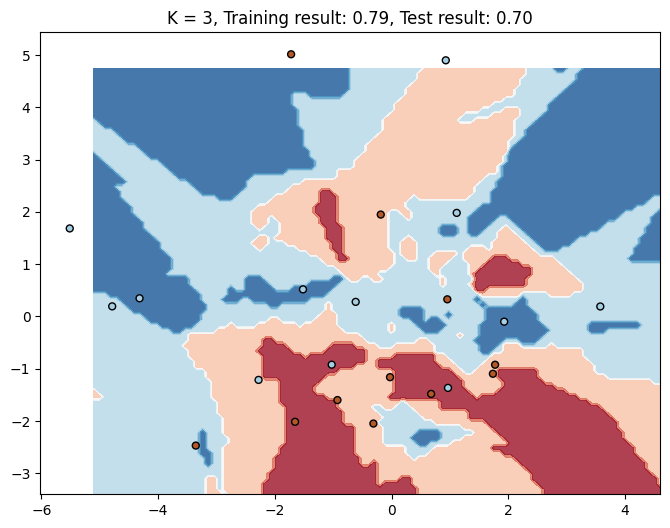

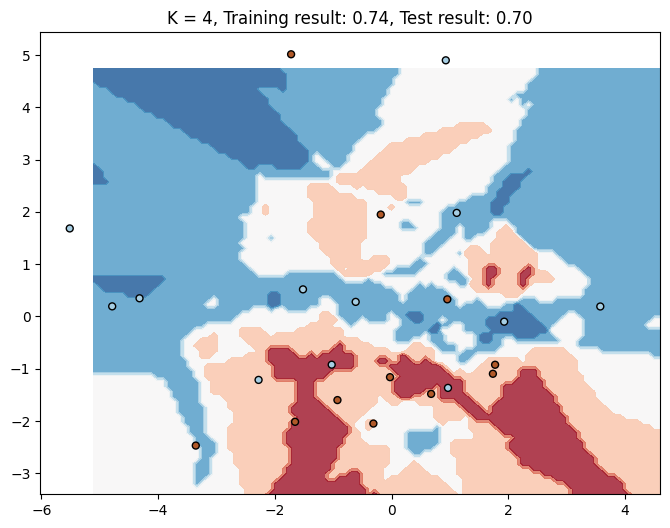

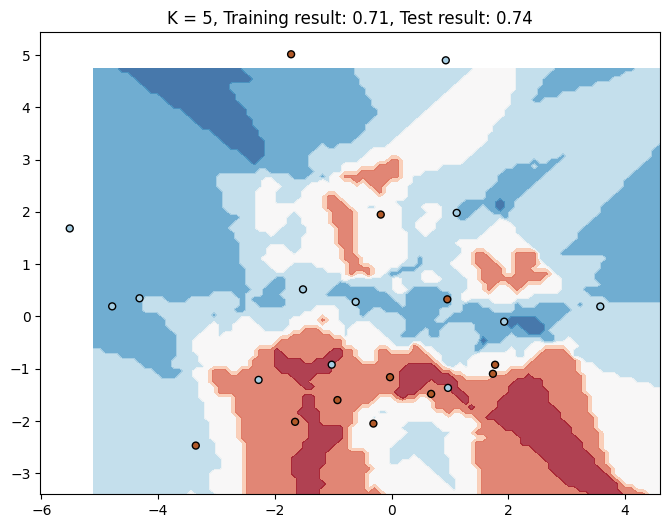

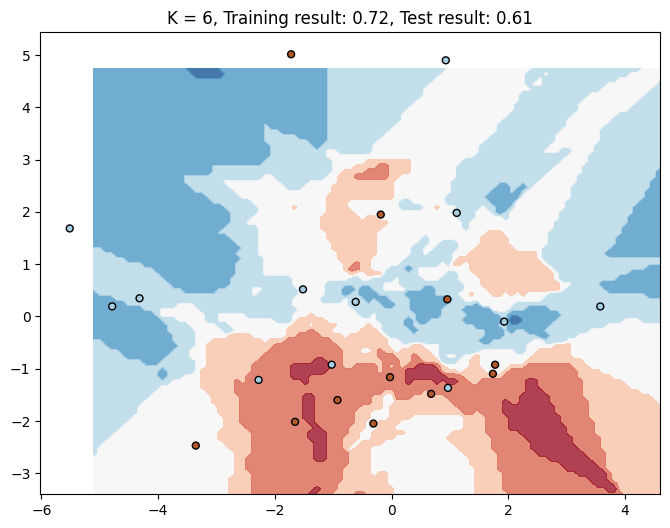

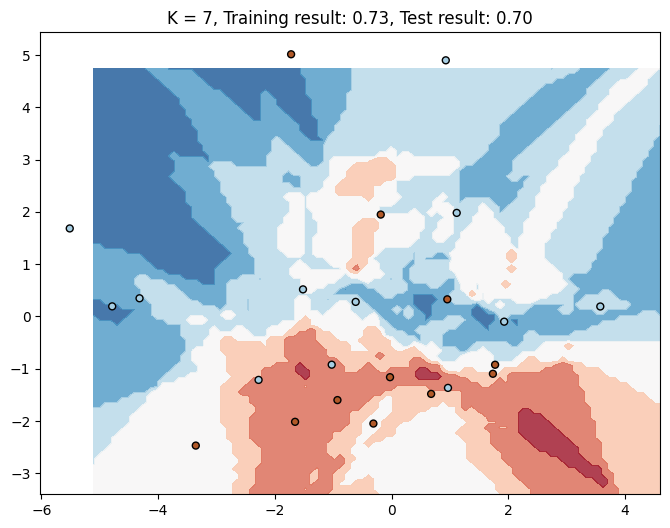

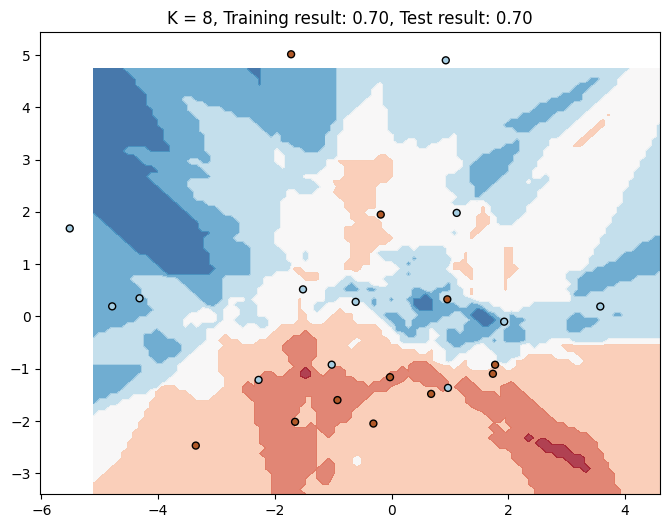

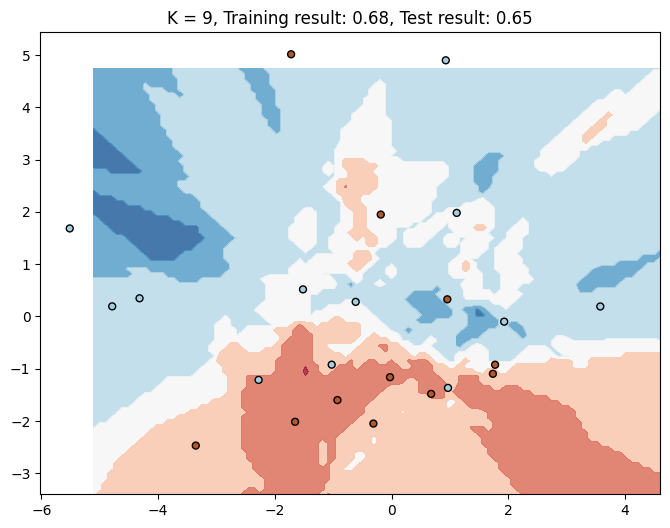

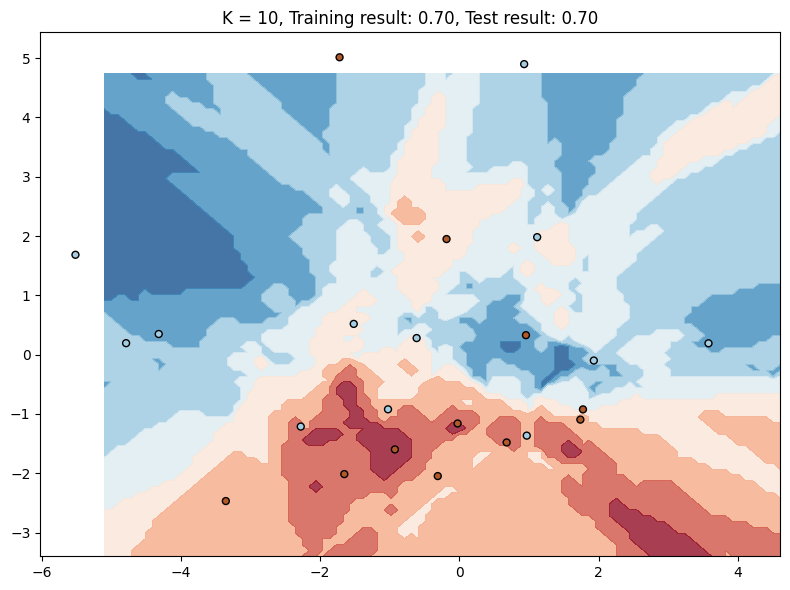

In [ ]:
# PCA toepassen
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)  # Fit PCA op de trainingsdata
X_train_pca = pca.transform(X_train_scaled)  # Transformeer de trainingsdata
X_test_pca = pca.transform(X_test_scaled)  # Transformeer de testdata

# Plot de PCA van de trainingsdata
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title('PCA plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Loop over verschillende k's
for k in range(1, 11):
    # Train kNN
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    score_train = knn.score(X_train_pca, y_train)
    score_test = knn.score(X_test_pca, y_test)

    # Plot de beslissingsgrenzen
    fig, ax = plt.subplots(figsize=(8, 6))
    colorplot(knn, ax, X_train_pca[:, 0], X_train_pca[:, 1])
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], marker='o', c=y_test,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
    ax.set_title(f"K = {k}, Training result: {score_train:.2f}, Test result: {score_test:.2f}")

plt.tight_layout()
plt.show()

In [ ]:
## Finding ID's with missing feature values
zero_value_feature = {}
for id in features.index:
    if (features.loc[id] == 0).any():
        zero_columns = features.columns[features.loc[id] == 0].tolist()  # Find columns where value is 0
        zero_value_feature[id] = zero_columns
    else:
        continue